# Social Networks Final Project: Protein-Protein Interactions (PPI)

**Group members:**

Marina Iuliana Aur, *1809715* <br>
Cristiana Di Tullio, *1803880*

## Import libraries and dependencies

In [ ]:
# Run if needed
# %pip install torch-geometric
# %pip install markov-clustering
# %pip install plotly
# %pip install igraph

In [100]:
# Import libraries
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import itertools
import pprint
import torch
from torch.cuda import is_available
from torch_geometric.utils import to_networkx, negative_sampling
import markov_clustering as mc
from scipy.sparse import csr_matrix

import plotly as py
import plotly.graph_objs as go
import igraph

In [ ]:
# CPU/GPU
device = 'cpu'
if torch.cuda.is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Utility functions

In [ ]:
# Graph visualization functions from the SNOM Lab
# NOTE: the original input object was not a normal networkx graph
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs = ['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize = (9, 7))
	nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
	plt.show()

In [ ]:
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")

## 1) Introduction


 ### 1.1) Dataset description and investigation

We downloaded protein-protein interaction (PPI) data from **BioGRID Project COVID-19** [[¹]](https://downloads.thebiogrid.org/File/BioGRID/Latest-Release/BIOGRID-PROJECT-covid19_coronavirus_project-LATEST.zip) dataset. In response to the COVID-19 pandemic, intensive efforts by the international research community have generated a vast amount of new data on Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2), the causal agent of COVID-19. This includes data on related coronaviruses such as SARS-CoV and MERS-CoV, which cause Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS), respectively.

Each row in the dataset represents a unique interaction between two proteins, allowing us to better understand the biology of the pathogen and facilitating the development of new therapeutic approaches. Specifically, the dataset includes information on all direct interactions between virally-encoded proteins and host cell proteins, as well as post-translational modifications and chemical interactions of viral proteins [[²]](https://thebiogrid.org/project/3/covid-19-coronavirus.html).


In [14]:
# Load PPI dataset
covid_df = pd.read_csv('BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.237.tab3.txt', sep = '\t')
covid_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,GU280_gp04,-,E,AP3B1,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001258698|NP_003655,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,GU280_gp04,-,E,BRD4,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001317313|NP_490597|NP_001366221|NP_0013662...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,GU280_gp04,DADB-17J1.3,E,BRD2,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,X5CF57|A0A024RCR5,NP_001186384|NP_005095|NP_001278915|NP_0011066...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,GU280_gp04,UNQ438/PRO871,E,CWC27,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,D6REK3,NP_001284574|NP_005860|NP_001351407|NP_0013049...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,GU280_gp04,-,E,ZC3H18,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,B4DTK7|E7ERS3,NP_653205|NP_001281269,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [15]:
# Display features overview
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44805 entries, 0 to 44804
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   #BioGRID Interaction ID             44805 non-null  int64 
 1   Entrez Gene Interactor A            44805 non-null  object
 2   Entrez Gene Interactor B            44805 non-null  object
 3   BioGRID ID Interactor A             44805 non-null  int64 
 4   BioGRID ID Interactor B             44805 non-null  int64 
 5   Systematic Name Interactor A        44805 non-null  object
 6   Systematic Name Interactor B        44805 non-null  object
 7   Official Symbol Interactor A        44805 non-null  object
 8   Official Symbol Interactor B        44805 non-null  object
 9   Synonyms Interactor A               44805 non-null  object
 10  Synonyms Interactor B               44805 non-null  object
 11  Experimental System                 44805 non-null  ob

In [18]:
# Check for missing values
covid_df.isna().sum()

,0
#BioGRID Interaction ID,0
Entrez Gene Interactor A,0
Entrez Gene Interactor B,0
BioGRID ID Interactor A,0
BioGRID ID Interactor B,0
Systematic Name Interactor A,0
Systematic Name Interactor B,0
Official Symbol Interactor A,0
Official Symbol Interactor B,0
Synonyms Interactor A,0


In [19]:
# Handling missing values
covid_df.dropna(inplace = True)

In [20]:
### Exploring interactions ###

organism_a_counts = covid_df['Organism Name Interactor A'].value_counts().reset_index()
organism_a_counts.columns = ['Organism', 'Count']

organism_b_counts = covid_df['Organism Name Interactor B'].value_counts().reset_index()
organism_b_counts.columns = ['Organism', 'Count']

num_colors_a = len(organism_a_counts)
num_colors_b = len(organism_b_counts)
colors_a = pc.sample_colorscale('Viridis', [n/(num_colors_a-1) for n in range(num_colors_a)])
colors_b = pc.sample_colorscale('Viridis', [n/(num_colors_b-1) for n in range(num_colors_b)])

# Plot
fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('Organism Name Interactor A',
                                                          'Organism Name Interactor B'), vertical_spacing = 0.4)

fig.add_trace(go.Bar(x = organism_a_counts['Organism'],
                     y = organism_a_counts['Count'],
                     orientation = 'v',
                     marker = dict(color = colors_a),
                     showlegend = False),
              row = 1, col = 1)

fig.add_trace(go.Bar(x = organism_b_counts['Organism'],
                     y = organism_b_counts['Count'],
                     orientation = 'v',
                     marker = dict(color = colors_b),
                     showlegend = False),
              row = 2, col = 1)

fig.update_yaxes(type = 'log', title_text = "count (log scale)", row = 1, col = 1)
fig.update_yaxes(type = 'log', title_text = "count (log scale)", row = 2, col = 1)
fig.update_xaxes(title_text = "organism", row = 1, col = 1)
fig.update_xaxes(title_text = "organism", row = 2, col = 1)
fig.update_layout(height = 1000,
                  title_text = "Distribution of Organism Name Interactor A e B",
                  showlegend = False)

fig.show()

In [21]:
### Exploring interactors ###

interactor_a = covid_df[['BioGRID ID Interactor A', 'Organism Name Interactor A']]
interactor_a.columns = ['BioGRID ID', 'Organism Name']

interactor_b = covid_df[['BioGRID ID Interactor B', 'Organism Name Interactor B']]
interactor_b.columns = ['BioGRID ID', 'Organism Name']

interactors = pd.concat([interactor_a, interactor_b])

id_grouped = interactors.groupby('BioGRID ID')['Organism Name'].nunique()

if all(id_grouped == 1):

    print("\n'BioGRID ID' corresponds to only one 'Organism Name' ---> It's a valid identifier for interactors!\n")

    interactors.drop_duplicates(subset = ['BioGRID ID'], inplace = True)

    organisms_counts = interactors['Organism Name'].value_counts().reset_index()
    organisms_counts.columns = ['Organism', 'Count']

    num_colors = len(organisms_counts)
    colors = pc.sample_colorscale('Plasma', [n / (num_colors - 1) for n in range(num_colors)])

    # Plot
    fig = px.bar(organisms_counts, x = 'Organism', y = 'Count',
                title = 'Organisms overall involved',
                color = 'Organism',
                color_discrete_sequence = colors)

    fig.update_layout(yaxis_type = 'log', yaxis_title = "count (log scale)", xaxis_title = "organism", height = 600, showlegend = False)

    fig.show()
else:
    print("[ERROR]: 'BioGRID ID' corresponds to more than one 'Organism Name'!")


'BioGRID ID' corresponds to only one 'Organism Name' ---> It's a valid identifier for interactors!



In [22]:
# Keeping only the interactions with High Throughput
filtered_df = covid_df[covid_df['Throughput'] == 'High Throughput']

print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')

Datasets size ratio: 0.9007
New dataset dimension: 40328 observations


In this project, we are especially interested in investigating the impact of the different Coronavirus agents on the human population and the structural relationships between their proteins. Therefore, we will limit our analysis to the interactor proteins belonging to the organism categories of Homo sapiens, SARS-CoV-2, SARS-CoV and MERS-CoV.

In [23]:
### Filtering by Organism Name ###

# Check all the organisms originally present in the dataset
print('Original organisms in the dataset:\n')
print(pd.concat([covid_df['Organism Name Interactor A'], covid_df['Organism Name Interactor B']]).unique())

# Select interactions where at least one organism is 'Homo sapiens'
human_df = filtered_df[(filtered_df['Organism Name Interactor A'] == 'Homo sapiens') | (filtered_df['Organism Name Interactor B'] == 'Homo sapiens')]
human_df = human_df.reset_index(drop = True)

print('\n-----------------------\n')
print('After filtering by "Homo sapiens":\n')
print(pd.concat([human_df['Organism Name Interactor A'], human_df['Organism Name Interactor B']]).unique())
print()
print('Datasets size ratio:', round(human_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', human_df.shape[0], 'observations')

# NEW FILTERING ---> to replace human_df
# Select interactions where both organisms are one of the following
organisms_of_interest = ['Homo sapiens',
                         'Severe acute respiratory syndrome coronavirus 2',
                         'Severe acute respiratory syndrome-related coronavirus',
                         'Middle-East Respiratory Syndrome-related Coronavirus']

filtered_df = filtered_df[(filtered_df['Organism Name Interactor A'].isin(organisms_of_interest)) &
                          (filtered_df['Organism Name Interactor B'].isin(organisms_of_interest))]
filtered_df = filtered_df.reset_index(drop = True)

# Check organisms in the dataset after filtering
print('\n-----------------------\n')
print('After filtering by "Homo sapiens", "SARS-2", "SARS" and "MERS":\n')
print(pd.concat([filtered_df['Organism Name Interactor A'], filtered_df['Organism Name Interactor B']]).unique())
print()
print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')

Original organisms in the dataset:

['Severe acute respiratory syndrome coronavirus 2' 'Homo sapiens'
 'Severe acute respiratory syndrome-related coronavirus'
 'Middle-East Respiratory Syndrome-related Coronavirus' 'Mus musculus'
 'Bos taurus' 'Macaca mulatta' 'Sus scrofa' 'Danio rerio'
 'Rattus norvegicus' 'Canis familiaris' 'Felis Catus'
 'Saccharomyces cerevisiae (S288c)' 'Schizosaccharomyces pombe (972h)'
 'Human Immunodeficiency Virus 1' 'Gallus gallus']

-----------------------

After filtering by "Homo sapiens":

['Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus' 'Homo sapiens'
 'Middle-East Respiratory Syndrome-related Coronavirus']

Datasets size ratio: 0.8907
New dataset dimension: 39883 observations

-----------------------

After filtering by "Homo sapiens", "SARS-2", "SARS" and "MERS":

['Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus' 'Homo sapiens'
 'Middle-

**[NOTA PER NOI]**: filtrando non solo per Homo Sapiens, ma anche per SARS-2, SARS e MERS, non diminuiamo molto il numero di nodi ma potrebbe essere più utile per controllare se nei nostri dati c'è *omofilia*. Vedi dopo.

In [25]:
# Drop duplicated interactions
filtered_df.drop_duplicates(subset = ['BioGRID ID Interactor A', 'BioGRID ID Interactor B'], keep = 'first', inplace = True)
filtered_df.reset_index(drop = True, inplace = True)

#filtered_df_for_graph = filtered_df[['BioGRID ID Interactor A', 'BioGRID ID Interactor B']]

print('Datasets size ratio:', round(filtered_df.shape[0] / covid_df.shape[0], 4))
print('New dataset dimension:', filtered_df.shape[0], 'observations')

Datasets size ratio: 0.6492
New dataset dimension: 29070 observations


We use the columns containing the **official symbols of the proteins** (`Official Symbol Interactor A` and` Official Symbol Interactor B`) to determine which proteins are involved in each interaction.

In [61]:
# Select PPI interactions
ppi = filtered_df[['BioGRID ID Interactor A', 'BioGRID ID Interactor B']]
ppi.head()

,BioGRID ID Interactor A,BioGRID ID Interactor B
0,4383845,114116
1,4383845,117036
2,4383845,111973
3,4383845,115572
4,4383845,125858


In [66]:
# Map BioGRID ID to its Official Symbol
map_id = {}

for _, row in filtered_df.iterrows():
    map_id[row['BioGRID ID Interactor A']] = row['Official Symbol Interactor A']
    map_id[row['BioGRID ID Interactor B']] = row['Official Symbol Interactor B']

In [62]:
# Save new interactions for Gephi visualization
ppi = ppi.rename(columns = {'BioGRID ID Interactor A': 'Source', 'BioGRID ID Interactor B': 'Target'})
ppi.to_csv('ppi_new_network.csv', index = False)

In [28]:
# Create file with nodes and labels
a = filtered_df[['BioGRID ID Interactor A', 'Organism Name Interactor A']]
a.columns = ['BioGRID ID', 'Organism Name']

b = filtered_df[['BioGRID ID Interactor B', 'Organism Name Interactor B']]
b.columns = ['BioGRID ID', 'Organism Name']

nodes_with_label = pd.concat([a, b])
nodes_with_label.drop_duplicates(inplace = True)

nodes_with_label = nodes_with_label.rename(columns = {'BioGRID ID': 'Id', 'Organism Name': 'Label'})
nodes_with_label.to_csv('nodes_with_label.csv', index = False)

### 1.2) Network analysis

The goal of the network analysis is to discover **patterns, relationships and properties** within a network by examining how proteins interact and influence one other.


#### Graph construction

In [80]:
# Check the shape of the dataframe without duplicates
ppi = ppi.drop_duplicates()
print('Shape of the PPI network after removing duplicates:', ppi.shape)

Shape of the PPI network after removing duplicates: (29070, 2)


In [81]:
ppi_network = nx.from_pandas_edgelist(ppi,
                                      source = 'Source',
                                      target = 'Target',
                                      create_using = nx.Graph())      # nx.Graph() doesn't allow duplicated edges

print(ppi_network) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 7118 nodes and 29010 edges


In [32]:
# Network object built from BioGRID IDs and containing Organism attributes
G = nx.Graph()

for idx, row in filtered_df.iterrows():
    G.add_edge(row['BioGRID ID Interactor A'], row['BioGRID ID Interactor B'])
    G.nodes[row['BioGRID ID Interactor A']]['Organism'] = row['Organism Name Interactor A']
    G.nodes[row['BioGRID ID Interactor B']]['Organism'] = row['Organism Name Interactor B']

print(G)
print(list(G.nodes.data())[1:10])

Graph with 7118 nodes and 29010 edges
[(114116, {'Organism': 'Homo sapiens'}), (117036, {'Organism': 'Homo sapiens'}), (111973, {'Organism': 'Homo sapiens'}), (115572, {'Organism': 'Homo sapiens'}), (125858, {'Organism': 'Homo sapiens'}), (121410, {'Organism': 'Homo sapiens'}), (4383846, {'Organism': 'Severe acute respiratory syndrome coronavirus 2'}), (114889, {'Organism': 'Homo sapiens'}), (116103, {'Organism': 'Homo sapiens'})]


In [33]:
# Identify self-loops
self_loops_bio = list(nx.selfloop_edges(ppi_network))
print('Number of self loops: ', len(self_loops_bio))
print('Self-loops over Total edges:', round(nx.number_of_selfloops(ppi_network) / len(ppi_network.edges), 4))

# Remove self-loops
ppi_network.remove_edges_from(self_loops_bio)
print('Graph without self-loops:', ppi_network)

Number of self loops:  49
Self-loops over Total edges: 0.0017
Graph without self-loops: Graph with 7118 nodes and 28961 edges


#### Giant Component

In many complex networks, such as protein-protein interactions (PPI) network, most of the nodes are part of a **single largest connected component (LCC)**, while the rest of the nodes may be contained in much smaller components. The giant component ensures that the network is interconnected, facilitating the *propagation of information*.

In [34]:
# Isolate the largest connected component (LCC)
components = list(nx.connected_components(ppi_network))
largest_component = max(components, key = len)
LCC_ppi = ppi_network.subgraph(largest_component)
print(LCC_ppi)

Graph with 7116 nodes and 28960 edges


#### Power-Law Degree Distribution

The degree distribution of the PPI network follows a **scale-free model**, where some proteins act like *hubs* with a very high degree, while most have only a few connections.

In [83]:
# Compute Degree Centrality
degree = LCC_ppi.degree()

# Compute (Normalized) Betweenness Centrality
bet = nx.betweenness_centrality(LCC_ppi, k = 100, normalized = True)

# Compute Eigenvector Centrality
eigen = nx.eigenvector_centrality(LCC_ppi, max_iter = 500, tol = 1e-04)

# Compute BetoverDeg Centrality
degree_dict = dict(degree)
ratio = {}

for node in LCC_ppi.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [69]:
# Insert metrics in the dictionary
nodes = LCC_ppi.nodes()
protein_measures = dict(nodes)

for protein in protein_measures:
    protein_measures[protein]['Degree'] = degree[protein]
    protein_measures[protein]['Betweeness'] = bet[protein]
    protein_measures[protein]['Eigen'] = eigen[protein]
    protein_measures[protein]['BetoverDeg'] = ratio[protein]

print_dict('Protein measures:', protein_measures)

Protein measures:
-----------------
{111973: {'BetoverDeg': 3.1805309531908948e-06,
          'Betweeness': 9.541592859572684e-06,
          'Degree': 3,
          'Eigen': 0.004722748545421923},
 114116: {'BetoverDeg': 1.6292868124015447e-06,
          'Betweeness': 6.517147249606179e-06,
          'Degree': 4,
          'Eigen': 0.005212512869836895},
 115572: {'BetoverDeg': 1.5061246904604412e-06,
          'Betweeness': 4.5183740713813235e-06,
          'Degree': 3,
          'Eigen': 0.0030284826137077984},
 117036: {'BetoverDeg': 0.0,
          'Betweeness': 0.0,
          'Degree': 1,
          'Eigen': 0.001821187237443763},
 4383845: {'BetoverDeg': 3.297561280503471e-05,
           'Betweeness': 0.035448783765412314,
           'Degree': 1075,
           'Eigen': 0.1849663621075335}}



In [98]:
# Build a metrics dataframe
measures_ppi = pd.DataFrame.from_dict(protein_measures, orient ='index')
measures_ppi = measures_ppi.reset_index()
measures_ppi.rename(columns={'index': 'Protein'}, inplace = True)

# Sort the output
sorted_metrics = measures_ppi.sort_values(by = 'Degree', ascending = False)
sorted_metrics.reset_index(drop = True, inplace = True)
sorted_metrics['Ranking'] = sorted_metrics.index + 1
sorted_metrics.set_index('Ranking', inplace = True)

# Visualize the output
sorted_metrics['Protein'] = sorted_metrics['Protein'].map(map_id)
sorted_metrics.head(15)

,Protein,Degree,Betweeness,Eigen,BetoverDeg
Ranking,,,,,
1,M,2036,0.165097,0.270370,0.000081
2,ORF7b,1751,0.128556,0.240957,0.000073
3,nsp6,1696,0.081327,0.243856,0.000048
4,nsp4,1493,0.047711,0.234767,0.000032
5,N,1477,0.127015,0.120348,0.000086
6,ORF8,1304,0.101400,0.156863,0.000078
7,S,1278,0.097678,0.161302,0.000076
8,ORF7a,1249,0.044428,0.205075,0.000036
9,ORF3a,1247,0.074196,0.179099,0.000059


The nodes with a higher degree are all proteins are encoded by coronaviruses:

- the **M** [[³]](https://thebiogrid.org/4383913/summary/severe-acute-respiratory-syndrome-related-coronavirus/m.html) protein (membrane glycoprotein) is crucial for virus assembly and budding,
- **ORF7b** [[⁴]](https://thebiogrid.org/4383871/summary/severe-acute-respiratory-syndrome-coronavirus-2/orf7b.html), **nsp6** [[⁵]](https://thebiogrid.org/4383855/summary/severe-acute-respiratory-syndrome-coronavirus-2/nsp6.html) and **nsp4** [[⁶]](https://thebiogrid.org/6222/summary/arabidopsis-thaliana/nsp4.html) proteins play a crucial role in modulating host cell functions and immune responses.

In relation to opinion dynamics, these nodes can be viewed as *influencers*, likely acting as **key regulatory nodes** (hubs) with influence over other nodes. Consequently, focusing on these proteins can help to identify potential targets for antiviral strategies and model how changes in these proteins might impact the virus life cycle.

In [74]:
# Display Average Degree
print('PPI Network Average degree:', np.mean(sorted_metrics.Degree))

PPI Network Average degree: 8.139404159640247


In [75]:
# Plot Degree Distribution
fig = px.histogram(sorted_metrics.Degree,
                   nbins = len(sorted_metrics.Degree.unique()),
                   title = 'Degree distribution')
fig.update_layout(yaxis_type = 'log', xaxis_title = 'degree', yaxis_title = 'count', bargap = 0.2)
fig.update_traces(marker_color = 'mediumslateblue')
fig.show()



The **heavy tail** of the power-law degree distribution supports the idea that the protein-protein interactions (PPI) network follows a scale-free model, where few highly connected proteins dominate while most have fewer interactions.

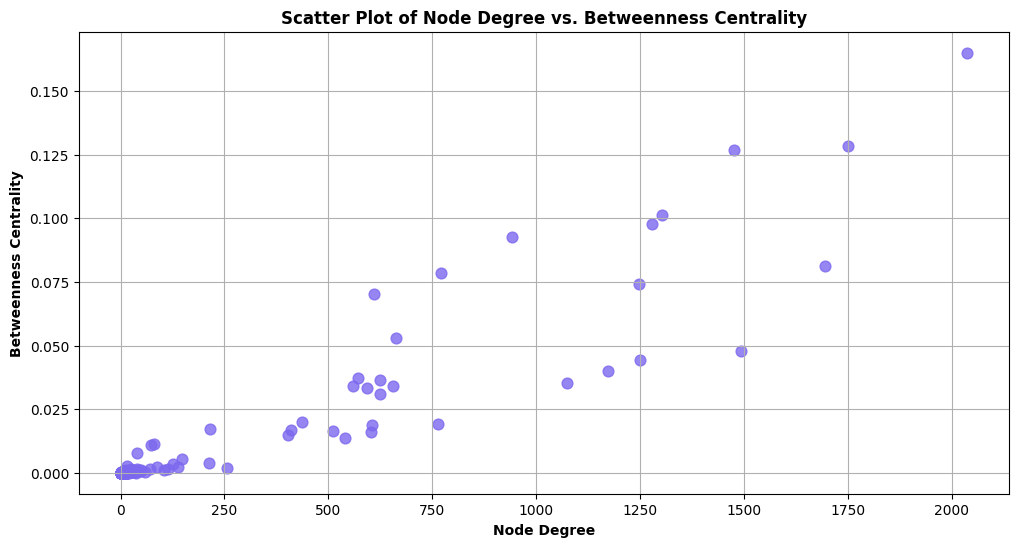

In [76]:
# Plot Scatterplot of Degree versus Betweeness
x = measures_ppi['Degree']
y = measures_ppi['Betweeness']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color = 'mediumslateblue', alpha = 0.8, s = 60)

plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight = 'bold')
plt.xlabel('Node Degree', fontweight = 'bold')
plt.ylabel('Betweenness Centrality', fontweight = 'bold')
plt.grid()
plt.show()

This scatter plot suggests that proteins with a higher degree in the PPI network tend to also have higher betweenness centrality, indicating that these proteins are also central to the **network's connectivity and structure**.

#### Globally Sparse, Locally Dense


Complex social networks are typically **gloabally sparse**, meaning that they have few edges compared to the number of potential connections. However, within these networks, connections are highly concentrated in **localized neighborhoods**.


Similarly, protein interactions are often sparse because not all proteins directly interact with one another. Instead, proteins tend to form modules, where each module represents a set of **related biological processes**.

In [84]:
# Compute Global Density
global_density = nx.density(LCC_ppi)
print(f'I Network Global Density: {global_density:.4f}')

# Compute Local Density
local_density = nx.average_clustering(LCC_ppi)
print(f'PPI Network Average Clustering Coefficient: {local_density:.4f}')

PPI Network Global Density: 0.0011
PPI Network Average Clustering Coefficient: 0.2907


#### Small-World Network

Small-world networks show both **high clustering coefficients** and **short average path lengths**. This means that while nodes in the network are highly local interconnected, any two nodes can be reached through a relatively small number of steps, resulting in efficient communication within the network.

In [79]:
# Compute Average Path Lenght
avg_path_length = nx.average_shortest_path_length(LCC_ppi)
print(f'PPI Network Average Path Length: {avg_path_length:.4f}')

PPI Network Average Path Length: 2.8594


**[NOTA PER NOI]** Ci mette infinito tempo a runnare la parte sotto

In [ ]:
# A graph is commonly classified as small-world if sigma > 1
sigma = nx.sigma(LCC_ppi, niter = 100, nrand = 10, seed = 42)
print(f'PPI Network Sigma: {sigma:.4f}')

# Values close to 0 mean that has small-world characteristics
omega = nx.omega(LCC_ppi, niter = 5, nrand = 10, seed = 42)
print(f'PPI Network Omega: {omega:.4f}')

### 1.3) Network visualization

**[Aggiungere Gephi visualization]**

In [ ]:
# Plot the PPI Largest Connected Component -> troppo grande?
pos = nx.spring_layout(LCC_ppi, seed=42)

plt.clf()
plt.figure(figsize = (14, 10))
nx.draw(LCC_ppi, pos, with_labels = True, node_color = 'violet', node_size = 1000,
        edge_color = 'gray', linewidths = 1, font_size = 16)

plt.title("PPI Largest connected Component Network", fontweight = 'bold')
plt.show()

In [ ]:
# CAREFUL
# Takes a while to plot
plt.figure(figsize = (9, 7))
nx.draw_spring(LCC_ppi, node_size = 30, arrows = False, node_color = 'mediumslateblue')
plt.title('Protein-Protein Interaction Network')
plt.show()

${TO-DO:}$ it still takes too much to run. Try to run it in Colab with the GPU.

## 2) Community detection

We experimented with clustering algorithms for community detection based on the **disease module hypothesis**. This hypothesis assumes that topological communities tend to be involved in similar biological processes and that the disease phenotype can be described by their breakdown.

In this context, we compared the outcomes of three algorithms that align with this assumption:

- **Kwik Cluster (or Pivot) Algorithm**
- **Markov Clustering (MCL) Algorithm**
- **Louvain Algorithm**

To ensure that the identified clusters are neither too specific nor too general, we have established **minimum and maximum thresholds** (`100 <= len(cluster) <= 1000`) to strike the right balance for cluster size.
These thresholds have led to improved outcomes in the subsequent stages of community detection.

### 2.1) KWIKCLUSTER (or PIVOT) Algorithm

**[Inserire commento introduttivo e/o pseudocodice]**

In [102]:
def kwik_cluster(G):
  clusters = []
  nodes = set(G.nodes)

  while nodes:
    # Select a random pivot
    pivot = random.choice(list(nodes))

    # Initialize the cluster with that pivot
    C = [pivot]

    # Remove the pivot from the remaining nodes
    nodes.remove(pivot)

    # Find all neighbors of the pivot
    for neighbor in list(nodes):
      if G.has_edge(pivot, neighbor):
        C.append(neighbor)
        # Remove the neighbor from remaining nodes
        nodes.remove(neighbor)

    # Add the cluster C to the list of clusters
    clusters.append(C)

  return clusters

In [134]:
# Compute KWIK clusters
KWIK_clusters = kwik_cluster(LCC_ppi)
print("Number of KWIK clusters: ", len(KWIK_clusters))

Number of KWIK clusters:  7028


In [179]:
# Select communities with a number of nodes between 100 and 1000
KWIK_clusters_filtered = [cluster for cluster in KWIK_clusters if 100 <= len(cluster) <= 1000]
print("Number of filtered KWIK clusters: ", len(KWIK_clusters_filtered))

Number of filtered KWIK clusters:  0


**[Spiegare perché non va bene]**

### 2.2) Markov Cluster Algorithm

The Markov Clustering (MCL) algorithm detects clusters by simulating **random flow** through a graph.  It essentially performs matrix multiplication on the adjacency matrix of the graph to propagate the flow between nodes.

In [169]:
# Convert the LCC_ppi network to a suitable format for MCL algorithm
matrix = nx.to_scipy_sparse_array(LCC_ppi)
matrix = csr_matrix(matrix)
matrix.shape

(7116, 7116)


The **inflation parameter** controls the granularity of clustering:

- Inflation > 1: increases the tendency to form smaller and more distinct clusters, resulting in a greater number of clusters.
- Inflation < 1: increases the tendency to form larger and more general clusters, resulsing in fewer clusters as the algorithm becomes less aggressive in clustering.

In [278]:
# Run the MCL algorithm with inflaction = 1.8
result = mc.run_mcl(matrix, inflation = 1.8)
MCL_clusters = mc.get_clusters(result)
print("Number of MCL clusters: ", len(MCL_clusters))

Number of MCL clusters:  46


In [279]:
# Select communities with a number of nodes between 100 and 1000
MCL_clusters_filtered = [cluster for cluster in MCL_clusters if 100 <= len(cluster) <= 1000]
print("Number of filtered MCL clusters: ", len(MCL_clusters_filtered))

Number of filtered MCL clusters:  8


In [280]:
for i, cluster in enumerate(MCL_clusters_filtered):
  print(f"Number of proteins in MCL Cluster {i + 1}: {len(cluster)}")

Number of proteins in MCL Cluster 1: 594
Number of proteins in MCL Cluster 2: 106
Number of proteins in MCL Cluster 3: 338
Number of proteins in MCL Cluster 4: 374
Number of proteins in MCL Cluster 5: 108
Number of proteins in MCL Cluster 6: 170
Number of proteins in MCL Cluster 7: 109
Number of proteins in MCL Cluster 8: 174


In [281]:
nodes = np.array(LCC_ppi.nodes())
MCL_clusters_filtered_2 = []
for cluster in MCL_clusters_filtered:
  cluster_names = [nodes[index] for index in cluster]
  MCL_clusters_filtered_2.append(cluster_names)

In [282]:
# positions = nx.spring_layout(LCC_ppi)
# mc.draw_graph(matrix, clusters, pos = positions, node_size = 50, with_labels = False, edge_color = "silver")

### 2.3) Louvain Algorithm

Louvain algorithm optimizes modularity by iteratively merging nodes into communities to maximize the **modularity score**.

The **resolution parameter** adjusts the scale of the communities detected:

- By increasing the sensitivity to modularity variations, the algorithm tends to identify smaller and more numerous communities.

- By decreasing the sensitivity to modularity variations, the algorithm tends to identify larger and fewer communities.

In [283]:
# Run the Louvain algorithm with gamma = 1.0
louvain_communities = nx.community.louvain_communities(LCC_ppi, weight = 'weight', resolution = 1.0, seed = 42)
print("Number of Louvain communities: ", len(louvain_communities))

Number of Louvain communities:  10


In [284]:
# Select communities with a number of nodes between 100 and 1000
louvain_communities_filtered = [community for community in louvain_communities if 100 <= len(community) <= 1000]
print("Number of filtered Louvain communities: ", len(louvain_communities_filtered))

Number of filtered Louvain communities:  9


In [285]:
for i, community in enumerate(louvain_communities_filtered):
  print(f"Number of proteins in Louvain Community {i + 1}: {len(community)}")

Number of proteins in Louvain Community 1: 690
Number of proteins in Louvain Community 2: 687
Number of proteins in Louvain Community 3: 931
Number of proteins in Louvain Community 4: 509
Number of proteins in Louvain Community 5: 543
Number of proteins in Louvain Community 6: 402
Number of proteins in Louvain Community 7: 367
Number of proteins in Louvain Community 8: 360
Number of proteins in Louvain Community 9: 891


### 2.4) Comparison of communities

In [294]:
overlap_info = {}

for i, louvain_community in enumerate(louvain_communities_filtered):
  louvain_community_proteins = set(louvain_community)
  max_overlap_count = 0
  max_overlap_cluster = None
  proteins_in_common = set()

  for j, mcl_cluster in enumerate(MCL_clusters_filtered_2):
    mcl_cluster_proteins = set(mcl_cluster)

    # Compute the overlap using intersection
    overlap_set = louvain_community_proteins.intersection(mcl_cluster_proteins)
    overlap_count = len(overlap_set)

    # Save the maximum overlap
    if overlap_count > max_overlap_count:
      max_overlap_count = overlap_count
      max_overlap_cluster = j
      proteins_in_common = overlap_set

    # Save the info in the dictionary
    overlap_info[i] = {
        'mcl_cluster': max_overlap_cluster + 1,
        'overlap_count': max_overlap_count,
        'proteins_in_common': list(proteins_in_common)
    }

  print(f"Louvain Community {i + 1} has the most overlap with MCL Cluster {max_overlap_cluster + 1} with {max_overlap_count} proteins in common.")

Louvain Community 1 has the most overlap with MCL Cluster 6 with 114 proteins in common.
Louvain Community 2 has the most overlap with MCL Cluster 1 with 371 proteins in common.
Louvain Community 3 has the most overlap with MCL Cluster 1 with 28 proteins in common.
Louvain Community 4 has the most overlap with MCL Cluster 3 with 256 proteins in common.
Louvain Community 5 has the most overlap with MCL Cluster 8 with 136 proteins in common.
Louvain Community 6 has the most overlap with MCL Cluster 1 with 27 proteins in common.
Louvain Community 7 has the most overlap with MCL Cluster 3 with 10 proteins in common.
Louvain Community 8 has the most overlap with MCL Cluster 3 with 8 proteins in common.
Louvain Community 9 has the most overlap with MCL Cluster 4 with 261 proteins in common.


In [299]:
overlap_proteins_filtered_map = [map_id[item] for item in overlap_info[1]['proteins_in_common'] if item in map_id]
for p in overlap_proteins_filtered_map:
  print(p)

GIT1
CLASP2
MCM9
ASF1B
STAT6
SRSF11
DBNL
NACAD
G6PC3
SOCS6
SEPT6
DPH7
TRIP12
LPIN1
SNAP29
SETD2
WIPF2
MDN1
BABAM1
UBE2T
C18orf25
RPAP2
CBLL1
LGALSL
TBC1D1
TAF9
PAN3
MRFAP1
SNRNP40
TCEAL4
SIX5
PTF1A
TMEM126B
SPATA31D4
SPATA31D3
PDZD7
NPC1L1
TCF7L2
ARHGEF6
TCF20
VPS72
DSN1
SATB2
DMAP1
FAM192A
ARHGEF12
ARHGEF18
ZNF362
BAG3
TEAD3
NRBF2
FTH1
PACSIN1
SPAG7
CCDC17
SIRT4
CEP41
FUS
NFE2L2
CXXC1
NFIL3
DNTTIP2
NFRKB
LSM14B
GABPB1
HEY1
MINK1
PHF3
MTL5
KIF12
DUX4
NOTCH4
DZIP3
COPS7A
CLINT1
RBFOX2
MAPK8IP2
C21orf59
SLC2A13
TP53BP1
DCAF11
GFI1
PATZ1
LMTK3
PDDC1
RABGAP1
RRP15
ORC1
IST1
CCDC50
TSC2
KCNH6
BBX
TTC4
CCDC124
TTN
TUBG1
PAK2
ZMAT2
PBX1
UBE2E2
ZNF653
TFIP11
SHC2
RGL3
PAK7
DCLRE1A
UNG
GPS1
GPS2
CIZ1
HSPA12B
RBM33
DOPEY2
SLC45A4
GPR63
SRA1
TRIM11
DFNB31
ZFP36L2
WARS
FRAT1
CHAF1A
GTF2E2
GTF2F1
GTF2F2
ABCC5
GUCY1A2
WWTR1
SYF2
PLEKHH1
CDC40
CACNA1B
CACNA1E
ZZZ3
STARD9
TOB1
PCDH11Y
HCFC1
RNF138
CALM3
WASF2
C12orf45
SORBS3
TRIAP1
RBM7
LSM14A
CWC15
TPH2
RTFDC1
HIVEP1
TXNDC9
CRAMP1L
EIF1
SLAIN2
RAB6B


## 3) Link Prediction with Graph Neural Networks (GNNs)

 ### 3.1) Exploring different models to perform the prediction task

 GAT, GCN, etc.

 Transformers?

### 3.2) Evaluation of results

(using metrics such as confusion matrix, accuracy, precision, recall, F1 score, hits@k, etc.)

## [Optional: Influence and Homophily?]

**[Spostare questa sezione subito dopo il Clustering]**

For any experiment in this area, we can take into consideration the Organism Interactor name as the "class" to which the proteins belong. Remember that in this dataset every row represent an interaction between two proteins, and we have both names of their organisms. We might need to build a new graph containing this information (the one we use for community detection just contains the protein names).

In [ ]:
# 1. [Indipendente dal clustering]
#    Visualizzare e commentare il numero di interazioni presenti nel dataset tra proteine
#    dello stesso organismo, ex: umano-umano, sars2-sars2, sars-sars, mers-mers
#    (NB: normalizziamo per numero di proteine per ogni organismo, perché per esempio le proteine umane sono
#     la categoria più presente)

# 2. [Dopo il clustering]
#    Visualizzare e commentare il numero di interazioni tra proteine dello stesso cluster,
#    che potrebbe indicare una tendenza a interagire tra proteine appartenenti allo stesso "processo biologico" (?) -> capire meglio che cos'è

## 4) Conclusions